# LAB SESSION 5 : Deep Learning for Graphs (1/2) 

MERRHEIM Maïssane 

# Lab 5 : Part 1 - DeepWalk, node embeddings and node classification

## Task 1 : deepwalk.py

In [109]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import numpy as np
import networkx as nx
from random import randint
from gensim.models import Word2Vec
import random


############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):

    ##############
    walk=[]
    for k in range(walk_length-1): 
        if list(G.neighbors(node)):
            random_node = random.choice(list(G.neighbors(node))) # we take a random node in the list of neighbours
            walk.append(node) #we add this node in the list walk
            node = random_node #the starting node becomes the random chosen node 
        else :
            break # no nodes 
    ##############
    
    walk = [str(node) for node in walk] #convert node into str in walk 
    return walk


## Task 2 : deepwalk.py

In [110]:

############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):

    ##############
    walks = []
    G_nodes = list(G.nodes())
    for node in G_nodes : # for each node
        for k in range(num_walks): 
            walk = random_walk(G,node,walk_length)
            walks.append(walk)
    random.shuffle(walks) # we permute the sublists for each node randomly
    ##############

    return walks

# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model


## Task 3 : visualization.py

In [111]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Loads the web graph
G = nx.read_weighted_edgelist('../data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
walks_web_graph = deepwalk(G,n_walks, walk_length,n_dim)


Number of nodes: 33226
Number of edges: 354529
Generating walks
Training word2vec


## Task 4 : visualization.py

In [112]:
############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):

    nodes = model.wv.index_to_key # your code here
    #nodes : index , node name
    DeepWalk_embeddings = np.empty(shape=(n, dim))
    
    ############## 
    freq_nodes=[]
    for node in nodes : 
        freq = model.wv.get_vecattr(node, "count") #returns the frequency of the node that apprear in the generates walks 
        freq_nodes.append(freq)

    sorted_freq_nodes = np.argsort(freq_nodes)[-100:]#100 nodes that appear most frequently in the generated walks

    L=[]
    for idx in sorted_freq_nodes : 
        L.append(nodes[idx])

    node_embeddings = [model.wv[node]for node in L]

    DeepWalk_embeddings = np.array(node_embeddings)  
    ############## 

    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):     
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    #plt.savefig('embeddings.pdf')  
    plt.show()

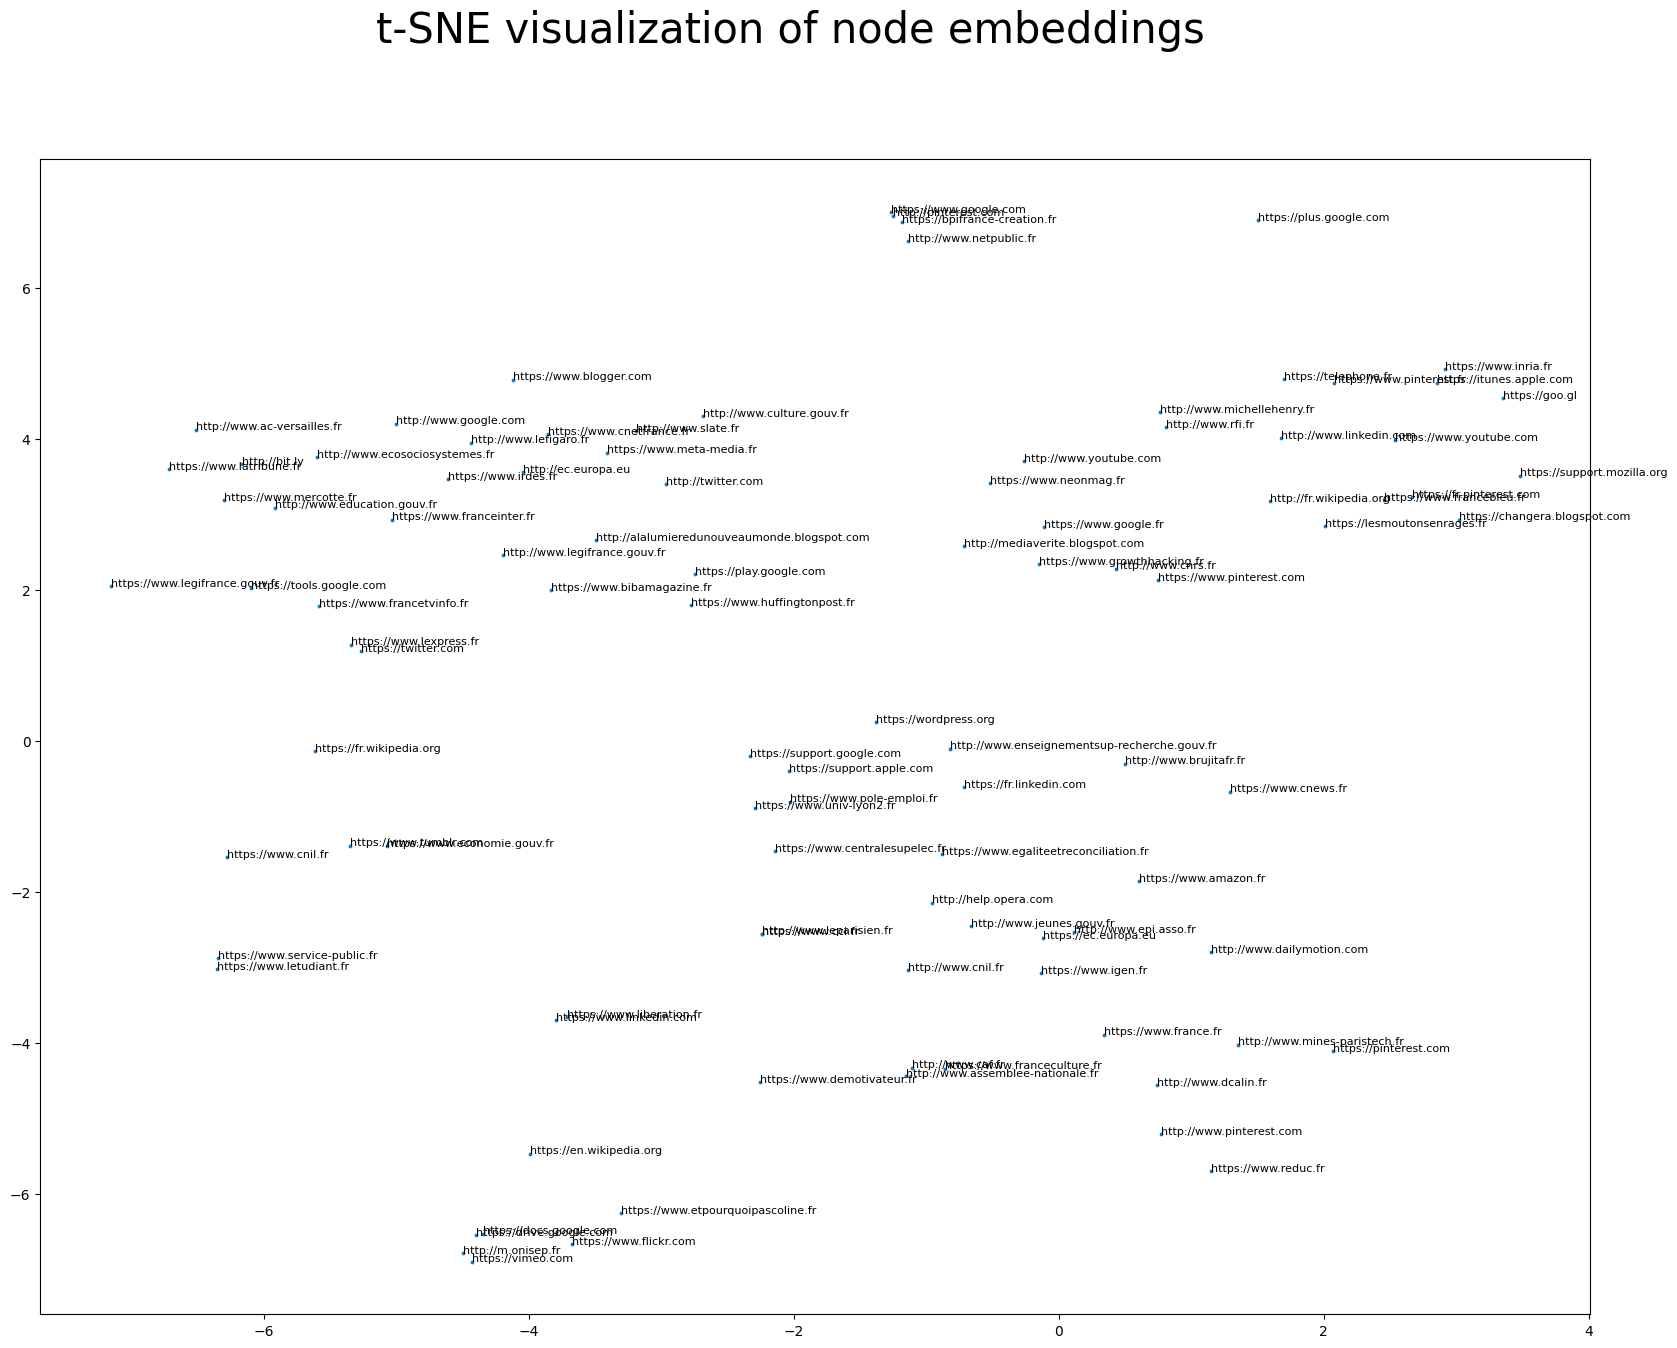

In [113]:
visualize(walks_web_graph, 100, n_dim)

## Task 5 : node_classification.py

Number of nodes: 34
Number of edges: 78


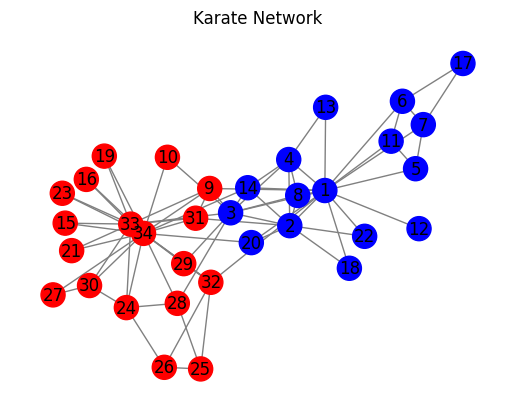

In [138]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score
from deepwalk import deepwalk
import matplotlib.pyplot as plt 


# Loads the karate network
G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)

############## Task 5
# Visualizes the karate network

##################
node_positions = nx.spring_layout(G)  
colors = ['r' if label == 1 else 'b' for label in y]
nx.draw_networkx(G, pos=node_positions, node_color=colors, with_labels=True, node_size=300, edge_color='gray')


plt.title("Karate Network")
plt.axis('off')
plt.show()
##################

## Task 6 : node_classification.py

In [116]:
############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model
    
model = deepwalk(G,n_walks, walk_length,n_dim) # your code here

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]

Generating walks
Training word2vec


## Task 7 : node_classification.py

In [117]:
############## Task 7
# Trains a logistic regression classifier and use it to make predictions

##################
LogisticRegressionModel = LogisticRegression()
LogisticRegressionModel.fit(X_train, y_train) #Training the model on the data
y_pred = LogisticRegressionModel.predict(X_test) #Predicts labels on the entire test dataset
accuracy = accuracy_score(y_test, y_pred) #Computes the classification accuracy
##################

In [118]:
print(accuracy)

1.0


## Task 8 : node_classification.py

In [141]:
############## Task 8
# Generates spectral embeddings

##################
def spectral_embedding(G):
    A = nx.adjacency_matrix(G)

   # Laplacian matrix L 
    I = eye(A.shape[0])
    degrees = dict(G.degree())
    nodes = list(G.nodes())
    diagonal_values = np.array( [degrees [node] for node in nodes])
    D_inverse = diags (1.0/diagonal_values)
    L = I - D_inverse@A

    # Eigenvalues of the Laplacian matrix 
    eigenvalues, L_embeddings = eigs(L,k=2,which='SR')
    L_embeddings = L_embeddings.real
   

    return L_embeddings

L_embeddings = spectral_embedding(G) # your code here

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = L_embeddings[idx_train,:]
X_test = L_embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]
##################

In [143]:
############## Task 7 bis
# Trains a logistic regression classifier and use it to make predictions

##################
LogisticRegressionModel = LogisticRegression()
LogisticRegressionModel.fit(X_train, y_train) 
y_pred = LogisticRegressionModel.predict(X_test) #Predicts labels on the entire test dataset
accuracy = accuracy_score(y_test, y_pred) 

print(accuracy)
##################

0.8571428571428571


# Lab 5 : Part 2 - Graph Neural Network 

## Task 9 : utils.py

In [139]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import scipy.sparse as sp
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

def normalize_adjacency(A):
    ############## Task 9

    ##################
    dim=A.shape[0]
    A_tild = A + sp.identity(dim)
    D_list=sp.csr_matrix.sum(A, axis=0)
    D_tild = sp.diags(D_list)  # Create a diag matrix from D_list

    D_sqrt = np.sqrt(D_list)  
    D_inv = sp.diags(1.0 / D_sqrt)
    
    A_normalized = D_inv @ A_tild @ D_inv
    
    ##################

    return A_normalized

def load_cora():
    idx_features_labels = np.genfromtxt("../data/cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    
    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("../data/cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


## Task 10 : models.py

In [122]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 
        
        ##################
        z = self.relu(torch.mm(adj,self.fc1(x_in)))
        z = self.dropout(z)
        z = self.relu(torch.mm(adj,self.fc2(z)))
        x = self.fc3(z)
        ##################

        return F.log_softmax(x, dim=1)



## Task 11 : gnn_karate.py

In [123]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.eye(n) # Generates node features


# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()


34
78
Epoch: 001 loss_train: 0.6981 acc_train: 0.4444 time: 0.0034s
Epoch: 002 loss_train: 0.6924 acc_train: 0.7037 time: 0.0015s
Epoch: 003 loss_train: 0.6871 acc_train: 0.5556 time: 0.0010s
Epoch: 004 loss_train: 0.6857 acc_train: 0.5556 time: 0.0010s
Epoch: 005 loss_train: 0.6788 acc_train: 0.5556 time: 0.0010s
Epoch: 006 loss_train: 0.6755 acc_train: 0.5556 time: 0.0010s
Epoch: 007 loss_train: 0.6637 acc_train: 0.5556 time: 0.0010s
Epoch: 008 loss_train: 0.6511 acc_train: 0.5556 time: 0.0010s
Epoch: 009 loss_train: 0.6424 acc_train: 0.5556 time: 0.0010s
Epoch: 010 loss_train: 0.6278 acc_train: 0.5926 time: 0.0010s
Epoch: 011 loss_train: 0.6171 acc_train: 0.7778 time: 0.0013s
Epoch: 012 loss_train: 0.5941 acc_train: 0.8889 time: 0.0013s
Epoch: 013 loss_train: 0.5734 acc_train: 0.8889 time: 0.0011s
Epoch: 014 loss_train: 0.5586 acc_train: 0.8889 time: 0.0011s
Epoch: 015 loss_train: 0.5307 acc_train: 0.8889 time: 0.0011s
Epoch: 016 loss_train: 0.5037 acc_train: 0.8889 time: 0.0011s
Ep

## Task 12 : gnn_karate.py

In [124]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix
############## Task 12
# Set the feature of all nodes to the same value
features = np.ones((n, n))  # Generates node features


# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)


# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()


34
78
Epoch: 001 loss_train: 0.6935 acc_train: 0.5556 time: 0.0020s
Epoch: 002 loss_train: 0.6863 acc_train: 0.5556 time: 0.0012s
Epoch: 003 loss_train: 0.6906 acc_train: 0.5556 time: 0.0010s
Epoch: 004 loss_train: 0.6828 acc_train: 0.5556 time: 0.0010s
Epoch: 005 loss_train: 0.6859 acc_train: 0.5556 time: 0.0011s
Epoch: 006 loss_train: 0.6831 acc_train: 0.6296 time: 0.0011s
Epoch: 007 loss_train: 0.6970 acc_train: 0.5556 time: 0.0015s
Epoch: 008 loss_train: 0.6865 acc_train: 0.6296 time: 0.0011s
Epoch: 009 loss_train: 0.6795 acc_train: 0.7407 time: 0.0014s
Epoch: 010 loss_train: 0.6840 acc_train: 0.6296 time: 0.0012s
Epoch: 011 loss_train: 0.6956 acc_train: 0.5185 time: 0.0011s
Epoch: 012 loss_train: 0.6779 acc_train: 0.6296 time: 0.0010s
Epoch: 013 loss_train: 0.6761 acc_train: 0.5556 time: 0.0012s
Epoch: 014 loss_train: 0.6735 acc_train: 0.5926 time: 0.0012s
Epoch: 015 loss_train: 0.6862 acc_train: 0.5556 time: 0.0010s
Epoch: 016 loss_train: 0.6858 acc_train: 0.5556 time: 0.0011s
Ep

## Task 13 : gnn_cora.py

Modify the code in the models.py file such that the model also returns the output of the second message passing layer. Then, in the gnn cora.py script, use slicing to retrieve the representa- tions of only the nodes of the test set. Transform the Torch tensor into a NumPy matrix (Hint: for a tensor T, you can do this using T.detach().cpu().numpy()). Project these representations to two dimensions using t-SNE (Hint: use scikit-learn’s implementation).

### models.py modified for task 13

In [127]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13
        
        ##################
        z = self.relu(torch.mm(adj,self.fc1(x_in)))
        z = self.dropout(z)
        z = self.relu(torch.mm(adj,self.fc2(z)))
        x = self.fc3(z)

        ##################

        return F.log_softmax(x, dim=1),z

In [136]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

Dataset has 2708 nodes, 5429 edges, 1433 features.


Epoch: 001 loss_train: 1.9559 acc_train: 0.1583 loss_val: 1.9443 acc_val: 0.1310 time: 0.0285s
Epoch: 002 loss_train: 1.9367 acc_train: 0.1576 loss_val: 1.9247 acc_val: 0.2417 time: 0.0316s
Epoch: 003 loss_train: 1.9161 acc_train: 0.2771 loss_val: 1.9038 acc_val: 0.3026 time: 0.0350s
Epoch: 004 loss_train: 1.8953 acc_train: 0.2993 loss_val: 1.8836 acc_val: 0.3026 time: 0.0261s
Epoch: 005 loss_train: 1.8728 acc_train: 0.2993 loss_val: 1.8594 acc_val: 0.3026 time: 0.0267s
Epoch: 006 loss_train: 1.8478 acc_train: 0.2993 loss_val: 1.8339 acc_val: 0.3026 time: 0.0273s
Epoch: 007 loss_train: 1.8224 acc_train: 0.2993 loss_val: 1.8137 acc_val: 0.3026 time: 0.0273s
Epoch: 008 loss_train: 1.7974 acc_train: 0.2993 loss_val: 1.8050 acc_val: 0.3026 time: 0.0487s
Epoch: 009 loss_train: 1.7810 acc_train: 0.2993 loss_val: 1.8020 acc_val: 0.3026 time: 0.0364s
Epoch: 010 loss_train: 1.7723 acc_train: 0.2993 loss_val: 1.7916 acc_val: 0.3026 time: 0.0254s
Epoch: 011 loss_train: 1.7551 acc_train: 0.2993 lo

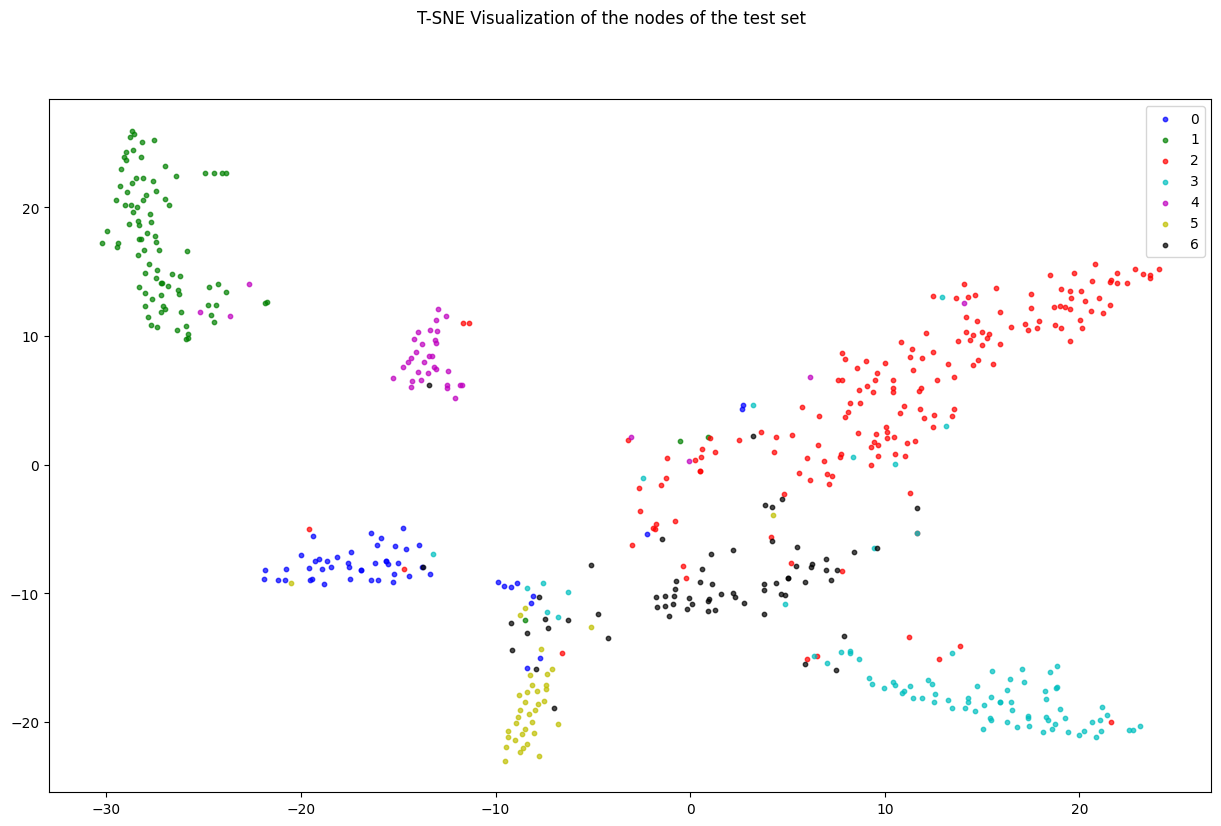

In [137]:

def normalize_adjacency(A):
    dim = A.shape[0]
    A_tild = A + sp.eye(dim)  

    D_list = np.array(A.sum(axis=1)).flatten() 
    D_tild = sp.diags(D_list, format='csr')  

    D_sqrt = np.sqrt(D_list)
    D_inv_sqrt = sp.diags(1.0 / D_sqrt, format='csr')

    A_normalized = D_inv_sqrt @ A_tild @ D_inv_sqrt

    return A_normalized

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()



############## Task 13
# Transforms torch tensor to numpy matrix

##################
embeddings_test_numpy = embeddings_test.detach().cpu().numpy()
##################


# Projects the emerging representations to two dimensions using t-SNE

##################
tsne = TSNE(n_components=2)
embeddings_test_2d = tsne.fit_transform(embeddings_test_numpy)
##################


labels = class_labels[idx_test]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()
